In [1]:
# enable data table display
# %load_ext google.colab.data_table
# to use the magic command
%load_ext google.cloud.bigquery
# import packages
from google.cloud import bigquery
import pandas as pd
import numpy as np

In [2]:
# project/data info
global project_id,data_set
project_id='tapad-dgx-stg'
dataset_id = 'dgx1420_representative_sampling_rjh_copy'
full_dataset_id = project_id + '.' + dataset_id 

client = bigquery.Client(project_id)
job_config = bigquery.QueryJobConfig()

In [3]:
def internal_execute_query(sql, job_config=None, print_sql = False, location='US'):
    if print_sql:
        print("sql ⬇ " + sql)

    if job_config is None:
        job = client.query(sql, location=location)
    else:
        job = client.query(
            sql, location=location, job_config=job_config
        )

    return job

def write_to_table(sql, dataset_id, tablename, write_type = "WRITE_EMPTY", print_sql = False):
    table_ref = client.dataset(dataset_id).table(tablename)
    job_config.destination = table_ref
    job_config.write_disposition = write_type

    query_job = internal_execute_query(
        sql, location='US', job_config=job_config
    )
    print(sql)
    query_job.result()
  
    print('Query results loaded to table {}'.format(table_ref.path))
    
    return(table_ref.path)


# Trying New Sampling Strategy

## IP address sampling

based on the canonical history table: 
- generate IPv4 subnet for each event, bucketize by n_devices per subnet, and pick 1/30 of them  
- because IP traffic dynamically changes, we probably need to generate a new subnet list each week

opt_puts_v001 -> so far let's leave it as untouched. 


**Input Table**

For quick test, we use the aggregated table as our input and sample our data from there. 

we have the following 4 aggregation tables: 
- agg_alias_table_v003
- agg_canonical_history_v002
- agg_location_info_v001
- opt_puts_v001

we use partition date = 2023-04-26 for aggregation -> corresponding to graph date 2023-05-02

**Output Table**
a sampled table corresponding to the following aggregation tables -> so we can override the table and run the hh build + ind build + rehydration
- sampled_agg_alias_table_v003
- sampled_agg_canonical_history_v002
- sampled_agg_location_info_v001
- opt_puts_v001 <- leave it untouched 

**Note**: those should be all partition tables if we wa`nt to use them in DAG


### Backing up data to personal dataset for messing around

In [ ]:

def produce_intermediate_tables(source, destination, partition_time):
    source_table = source['project_id'] + '.' + source['dataset'] + '.' + source['table']
    destination_table = destination['project_id'] + '.' + destination['dataset'] + '.' + destination['table']
    sql = f'''SELECT * FROM `{source_table}` WHERE DATE(_PARTITIONTIME) = "{partition_time}"'''
    write_to_table(sql,  destination_dataset, f'''{destination['table']}_{partition_time.replace('-','')}''')
    return 

# Only run these cells for initial pass, though write mode should prevent overwrite

In [ ]:
source = {'project_id': 'tapad-identity-stg',
          'dataset': 'dgx1420_fullscale_ttd_backup',
           'table':  'agg_location_info_v001'}
destination = {'project_id': 'tapad-dgx-stg',
          'dataset': 'dgx1420_representative_sampling_rjh_copy',
           'table':  'agg_location_info_v001'}

produce_intermediate_tables(source, destination, partition_time = "2023-04-19")
produce_intermediate_tables(source, destination, partition_time = "2023-04-26")

source['table'] = 'agg_canonical_history_v002'
destination['table'] = source['table']
produce_intermediate_tables(source, destination, partition_time = "2023-04-19")
produce_intermediate_tables(source, destination, partition_time = "2023-04-26")

source['table'] = 'agg_device_info_v001'
destination['table'] = source['table']
produce_intermediate_tables(source, destination, partition_time = "2023-04-19")
produce_intermediate_tables(source, destination, partition_time = "2023-04-26")

source['table'] = 'agg_alias_table_v003'
destination['table'] = source['table']
produce_intermediate_tables(source, destination, partition_time = "2023-04-19")
produce_intermediate_tables(source, destination, partition_time = "2023-04-26")

source['table'] = 'agg_device_info_v001'
destination['table'] = source['table']
produce_intermediate_tables(source, destination, partition_time = "2023-04-26")

# Starting here we aren't in danger of overwriting.

In [ ]:
## Get a look at the distribution of canonicals by ip addresses and also subnets 

In [4]:
source_table =   dataset_id  + '.agg_canonical_history_v002_20230419'

sql = f'''
SELECT 
    canonical_cnt, 
    COUNT(1) as ip_count 
FROM 
    (
        SELECT 
            ip_address, 
            COUNT(1) as canonical_cnt
        FROM
        (
            SELECT * 
            FROM `{source_table}` LIMIT 2000000000
        )A , UNNEST(A.history) h 
        GROUP BY ip_address
    )
GROUP BY canonical_cnt
ORDER BY canonical_cnt 
'''

df_20230419_ipdist = client.query(sql).result().to_dataframe()


<AxesSubplot: xlabel='canonical_cnt'>

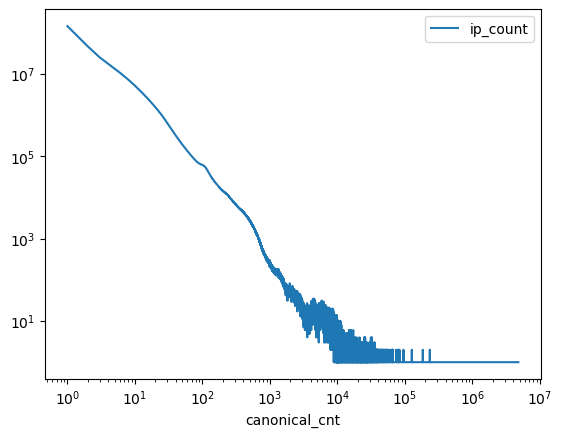

In [5]:
source_table =   dataset_id  + '.agg_canonical_history_v002_20230426'

sql = f'''
SELECT canonical_cnt, COUNT(1) as ip_count FROM (
SELECT ip_address, COUNT(1) as canonical_cnt
FROM
(
SELECT * from `{source_table}` LIMIT 2000000000
)
A , UNNEST(A.history) h 
GROUP BY ip_address
)

GROUP BY canonical_cnt
ORDER BY canonical_cnt 
'''

df_20230426_ipdist = client.query(sql).result().to_dataframe()
df_20230426_ipdist.plot(x = 'canonical_cnt', y = 'ip_count', loglog = True)

In [6]:
sql = f'''
  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        CASE 
            split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `{dataset_id}.agg_canonical_history_v002_20230419` , unnest(history) as history
 )
SELECT 
    subnet, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM cte 
GROUP BY 1,2
'''
write_to_table(sql, dataset_id, 'subnet_device_count_20230419')


  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        CASE 
            split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `dgx1420_representative_sampling_rjh_copy.agg_canonical_history_v002_20230419` , unnest(history) as history
 )
SELECT 
    subnet, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_d

BadRequest: 400 Syntax error: Unexpected keyword AS at [19:179]

Location: US
Job ID: 17516592-6abd-4511-be27-0383f11af448


In [7]:
sql = f'''
  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `{dataset_id}.agg_canonical_history_v002_20230426` , unnest(history) as history
 )
SELECT 
    subnet, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM cte 
GROUP BY 1,2
'''
write_to_table(sql, dataset_id, 'subnet_device_count_20230426')


  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `dgx1420_representative_sampling_rjh_copy.agg_canonical_history_v002_20230426` , unnest(history) as history
 )
SELECT 
    subnet, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM cte 


Conflict: 409 Already Exists: Table tapad-dgx-stg:dgx1420_representative_sampling_rjh_copy.subnet_device_count_20230426

Location: US
Job ID: 8df217f8-a0e7-4a6d-b45f-59781a176459


In [9]:
sql = f'''
  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `{dataset_id}.agg_canonical_history_v002_20230419` , unnest(history) as history
 )
SELECT 
    ip_address, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM cte 
GROUP BY 1,2
'''
write_to_table(sql, dataset_id, 'ip_device_count_20230419')


  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `dgx1420_representative_sampling_rjh_copy.agg_canonical_history_v002_20230419` , unnest(history) as history
 )
SELECT 
    ip_address, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM c

Conflict: 409 Already Exists: Table tapad-dgx-stg:dgx1420_representative_sampling_rjh_copy.ip_device_count_20230419

Location: US
Job ID: ba566ed3-8045-4d3f-afd8-378e26e49c60


In [8]:
sql = f'''
  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `{dataset_id}.agg_canonical_history_v002_20230426` , unnest(history) as history
 )
SELECT 
    ip_address, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM cte 
GROUP BY 1,2
'''
write_to_table(sql, dataset_id, 'ip_device_count_20230426')


  CREATE TEMPORARY FUNCTION
                  reduce_to_cookie_or_hardware_id_type(id_type INT64) AS ((
                    SELECT
                      CASE
                        WHEN id_type IN (11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                            22, 23, 24, 25, 26, 27, 28, 29, 30, 31) THEN 1
                      ELSE
                      0
                    END
                      ));
WITH cte as 
(
    SELECT 
        canonical_id, 
        reduce_to_cookie_or_hardware_id_type(id_type) as cookie_or_hardware, 
        history.ip_address as ip_address ,
        split(history.ip_address, '.')[safe_ordinal(1)] || '.' || split(history.ip_address, '.')[safe_ordinal(2)]  || '.' || split(history.ip_address, '.')[safe_ordinal(3)]  as subnet  
    FROM `dgx1420_representative_sampling_rjh_copy.agg_canonical_history_v002_20230426` , unnest(history) as history
 )
SELECT 
    ip_address, 
    cookie_or_hardware, 
    count(distinct canonical_id) as n_devices 
FROM c

'/projects/tapad-dgx-stg/datasets/dgx1420_representative_sampling_rjh_copy/tables/ip_device_count_20230426'

In [15]:
source_table =   dataset_id  + '.ip_device_count_20230419'

sql = f'''
SELECT 
    cookie_canonical_cnt,
    hardware_canonical_cnt, 
    COUNT(DISTINCT ip_address) as ip_count 
FROM 
    (
        SELECT 
            ip_address, 
            SUM(n_devices * cookie_or_hardware) as cookie_canonical_cnt,
            SUM(n_devices * (1 - cookie_or_hardware)) as hardware_canonical_cnt
        FROM `{source_table}` 
        GROUP BY ip_address
    )
GROUP BY cookie_canonical_cnt, hardware_canonical_cnt
ORDER BY 1,2
'''

df_ipdist = client.query(sql).result().to_dataframe()


In [17]:
source_table =   dataset_id  + '.ip_device_count_20230426'

sql = f'''
SELECT 
    cookie_canonical_cnt,
    hardware_canonical_cnt, 
    COUNT(DISTINCT ip_address) as ip_count 
FROM 
    (
        SELECT 
            ip_address, 
            SUM(n_devices * cookie_or_hardware) as cookie_canonical_cnt,
            SUM(n_devices * (1 - cookie_or_hardware)) as hardware_canonical_cnt
        FROM `{source_table}` 
        GROUP BY ip_address
    )
GROUP BY cookie_canonical_cnt, hardware_canonical_cnt
ORDER BY 1,2
'''

df1_ipdist = client.query(sql).result().to_dataframe()


In [33]:
df_ipdist.groupby('cookie_canonical_cnt').agg({'ip_count': sum}).reset_index()

,cookie_canonical_cnt,ip_count
0,0,94149844
1,1,106016990
2,2,34973498
3,3,26952881
4,4,23025896
...,...,...
81540,6788793,1
81541,6790561,1
81542,6790969,1
81543,6803437,1


Text(0, 0.5, 'ips containing n cookie / hardware canonicals')

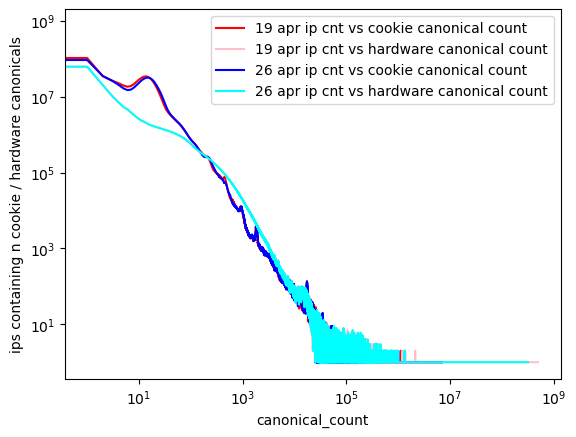

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_ipdist.groupby('cookie_canonical_cnt').agg({'ip_count': sum}).reset_index().plot(x = 'cookie_canonical_cnt', y = 'ip_count', loglog = True, ax = ax, label='19 apr ip cnt vs cookie canonical count', color='red')
df_ipdist.groupby('hardware_canonical_cnt').agg({'ip_count': sum}).reset_index().plot(x = 'hardware_canonical_cnt', y = 'ip_count', loglog = True, ax = ax, label='19 apr ip cnt vs hardware canonical count',color='pink')
df1_ipdist.groupby('cookie_canonical_cnt').agg({'ip_count': sum}).reset_index().plot(x = 'cookie_canonical_cnt', y = 'ip_count', loglog = True, ax = ax, label='26 apr ip cnt vs cookie canonical count', color='blue')
df1_ipdist.groupby('hardware_canonical_cnt').agg({'ip_count': sum}).reset_index().plot(x = 'hardware_canonical_cnt', y = 'ip_count', loglog = True, ax = ax, label='26 apr ip cnt vs hardware canonical count', color = 'cyan')
ax.set_xlabel('canonical_count')
ax.set_ylabel('ips containing n cookie / hardware canonicals')

In [41]:
sql = f'''

CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  subnet,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `{dataset_id}.subnet_device_count_20230419`
WHERE subnet IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
  subnet,
  cookie_or_hardware,
  n_devices, 
  n_devices_deciles(n_devices, d.deciles) AS n_device_bucket
FROM
  agg_ip_device_cnt 
CROSS JOIN
  deciles AS d

'''
write_to_table(sql, dataset_id, 'agg_subnet_device_count_with_bucket_20230419')



CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  subnet,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `dgx1420_representative_sampling_rjh_copy.subnet_device_count_20230419`
WHERE subnet IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
  sub

Conflict: 409 Already Exists: Table tapad-dgx-stg:dgx1420_representative_sampling_rjh_copy.agg_subnet_device_count_with_bucket_20230419

Location: US
Job ID: 7e0b8c8f-3fc5-412f-a2ce-b9c4ddf7c770


In [40]:
sql = f'''

CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  subnet,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `{dataset_id}.subnet_device_count_20230426`
WHERE subnet IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
  subnet,
  cookie_or_hardware,
  n_devices, 
  n_devices_deciles(n_devices, d.deciles) AS n_device_bucket
FROM
  agg_ip_device_cnt 
CROSS JOIN
  deciles AS d

'''
write_to_table(sql, dataset_id, 'agg_subnet_device_count_with_bucket_20230426')



CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  subnet,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `dgx1420_representative_sampling_rjh_copy.subnet_device_count_20230426`
WHERE subnet IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
  sub

'/projects/tapad-dgx-stg/datasets/dgx1420_representative_sampling_rjh_copy/tables/agg_subnet_device_count_with_bucket_20230426'

In [42]:
sql = f'''

CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  ip_address,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `{dataset_id}.ip_device_count_20230419`
WHERE ip_address IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
  ip_address,
  cookie_or_hardware,
  n_devices, 
  n_devices_deciles(n_devices, d.deciles) AS n_device_bucket
FROM
  agg_ip_device_cnt 
CROSS JOIN
  deciles AS d

'''
write_to_table(sql, dataset_id, 'agg_ip_device_count_with_bucket_20230419')



CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  ip_address,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `dgx1420_representative_sampling_rjh_copy.ip_device_count_20230419`
WHERE ip_address IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
 

'/projects/tapad-dgx-stg/datasets/dgx1420_representative_sampling_rjh_copy/tables/agg_ip_device_count_with_bucket_20230419'

In [43]:
sql = f'''

CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  ip_address,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `{dataset_id}.ip_device_count_20230426`
WHERE ip_address IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
  ip_address,
  cookie_or_hardware,
  n_devices, 
  n_devices_deciles(n_devices, d.deciles) AS n_device_bucket
FROM
  agg_ip_device_cnt 
CROSS JOIN
  deciles AS d

'''
write_to_table(sql, dataset_id, 'agg_ip_device_count_with_bucket_20230426')



CREATE TEMPORARY FUNCTION
  n_devices_deciles(n_devices INT64, deciles ARRAY<INT64>) AS (
    CASE
      WHEN n_devices IS NULL THEN NULL
      WHEN n_devices > deciles[ORDINAL(10)] THEN 10
      WHEN n_devices > deciles[ORDINAL(9)] THEN 9
      WHEN n_devices > deciles[ORDINAL(8)] THEN 8
      WHEN n_devices > deciles[ORDINAL(7)] THEN 7
      WHEN n_devices > deciles[ORDINAL(6)] THEN 6
      WHEN n_devices > deciles[ORDINAL(5)] THEN 5
      WHEN n_devices > deciles[ORDINAL(4)] THEN 4
      WHEN n_devices > deciles[ORDINAL(3)] THEN 3
      WHEN n_devices > deciles[ORDINAL(2)] THEN 2
      ELSE 1
    END
  );



WITH
  agg_ip_device_cnt AS (
SELECT
  ip_address,
  cookie_or_hardware,
  SUM(n_devices) as n_devices
FROM
  `dgx1420_representative_sampling_rjh_copy.ip_device_count_20230426`
WHERE ip_address IS NOT NULL
    AND cookie_or_hardware IS NOT NULL
GROUP BY 
1,2
),
  deciles AS (
SELECT
  APPROX_QUANTILES(n_devices, 10 IGNORE NULLS) AS deciles
FROM
  agg_ip_device_cnt
)

SELECT
 

'/projects/tapad-dgx-stg/datasets/dgx1420_representative_sampling_rjh_copy/tables/agg_ip_device_count_with_bucket_20230426'

In [44]:
source_table = dataset_id + '.' + 'agg_subnet_device_count_with_bucket_20230419'
sql = f'''
SELECT * 
FROM 
`{source_table}` 
'''
df_20230419_subnets = client.query(sql).result().to_dataframe()

source_table = dataset_id + '.' + 'agg_subnet_device_count_with_bucket_20230426'
sql = f'''
SELECT * 
FROM 
`{source_table}` 
'''
df_20230426_subnets = client.query(sql).result().to_dataframe()

In [47]:
quantile_positions_20230419 = df_20230419_subnets.groupby('n_device_bucket').agg({'n_devices':min})['n_devices'].to_list()
quantile_positions_20230426 = df_20230426_subnets.groupby('n_device_bucket').agg({'n_devices':min})['n_devices'].to_list()

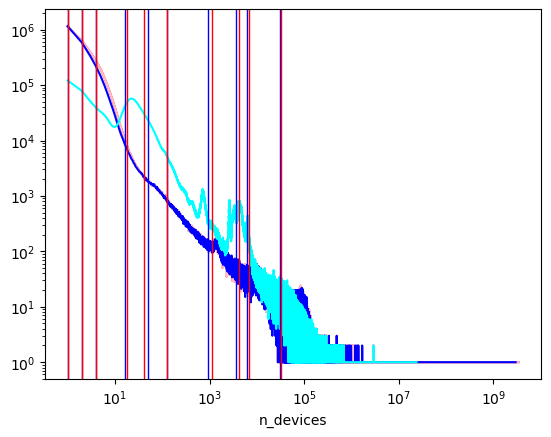

In [57]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
df_20230419_subnets[df_20230419_subnets['cookie_or_hardware'] == 0].groupby('n_devices').size().plot(loglog=True, ax=ax, color = 'red', marker = '', label = 'cookie 0419')
df_20230419_subnets[df_20230419_subnets['cookie_or_hardware'] == 0].groupby('n_devices').size().plot(loglog=True, ax=ax, color = 'pink', marker = '', label = 'hardware 0419')
df_20230426_subnets[df_20230426_subnets['cookie_or_hardware'] == 0].groupby('n_devices').size().plot(loglog=True, ax=ax, color = 'blue', marker = '', label = 'cookie 0426')
df_20230426_subnets[df_20230426_subnets['cookie_or_hardware'] == 1].groupby('n_devices').size().plot(loglog=True, ax=ax, color = 'cyan', marker = '', label = 'hardware 0426')

[ax.axvline(_x, linewidth=1, color='blue') for _x in quantile_positions_20230419]
[ax.axvline(_x, linewidth=1, color='red') for _x in quantile_positions_20230426]

project_id='tapad-identity-prd'
dataset_id = 'dg_external_us'
full_dataset_id = project_id + '.' + dataset_id 
